

| Model                | RMSE (Mean) | RMSE (Std)  | R² (Mean) | R² (Std)   |
|----------------------|-------------|-------------|-----------|------------|
| OLS Linear Regression| 365.2550    | 83.1106     | 0.8104    | 0.0643     |
| Gradient Boosting    | 392.6943    | 178.3381    | 0.7837    | 0.1458     |
| Random Forest        | 386.3677    | 182.5722    | 0.8057    | 0.1025     |
| LightGBM             | 469.5300    | 190.3763    | 0.7016    | 0.1548     |


In [19]:
import pandas as pd

# 读入CSV文件
df = pd.read_csv('final_merged_cleaned.csv', na_values=['..', '', 'NA', 'N/A'])

# 显示所有字段名
print(df.columns.tolist())

['Local_Authority_Code', 'Local_Authority_Name', 'Agricultural_and_Rural', 'Natural_Ecological_and_Public', 'Residential_and_Commercial', 'Household_composition', 'Population_Density_Persons_per_square_kilometre', 'ethnic_groups', 'language_fluency', 'health', 'Occupancy_rating_for_bedrooms', 'education', 'Median_House_Price', 'Mid-2022', 'Accommodation_Food_POI', 'Arts_Recreation_POI', 'Financial_Institutions_POI', 'Healthcare_Centers_POI', 'Information_Communication_POI', 'OtherPOI', 'Personal_Household_Svcs_POI', 'Retail_POI', 'Transportation_Facilities_POI', 'Total_owed_a_prevention_or_relief_duty', 'Total_recorded_ASB', 'Environmental_ASB', 'Nuisance_ASB', 'Personal_ASB', 'Total_recorded_crime_(excluding_fraud)', 'Violence_against_the_person', 'Environmental_ASB_rate', 'Nuisance_ASB_rate', 'Personal_ASB_rate', 'Total_recorded_crime_(excluding_fraud)_rate', 'Violence_against_the_person_rate', 'Total_owed_a_prevention_or_relief_duty_rate', 'Total_owed_a_prevention_or_relief_duty_rat

In [20]:
import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 1. 变量列表
socio_vars = [
    'Population_Density_Persons_per_square_kilometre', 'ethnic_groups', 'language_fluency', 
    'health', 'Occupancy_rating_for_bedrooms', 'education', 'Median_House_Price', 
    'Environmental_ASB', 'Nuisance_ASB', 'Personal_ASB', 
    'Total_recorded_crime_(excluding_fraud)','Violence_against_the_person'
    
]
built_vars = [
    'Agricultural_and_Rural', 'Natural_Ecological_and_Public', 'Residential_and_Commercial',
    'Accommodation_Food_POI', 'Arts_Recreation_POI', 'Financial_Institutions_POI', 'Healthcare_Centers_POI', 
    'Information_Communication_POI', 'OtherPOI', 'Personal_Household_Svcs_POI', 'Retail_POI', 'Transportation_Facilities_POI'
]

all_vars = socio_vars + built_vars
target = 'Total_owed_a_prevention_or_relief_duty'


# 变量列表同前

X = df[all_vars].copy()
y = df[target].copy()

# 数据清洗
X = X.apply(pd.to_numeric, errors='coerce')
y = pd.to_numeric(y, errors='coerce')
X = X.dropna()
y = y.loc[X.index]

# 现在可以安全计算相关性了
target_corr = X.apply(lambda col: abs(np.corrcoef(col, y)[0, 1]))


# 4. 剔除高度相关变量，保留与因变量相关性高的
def remove_highly_correlated(X, y, threshold=0.95):
    X = X.copy()
    corr_matrix = X.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    # 计算每个自变量与y的相关性（绝对值）
    target_corr = X.apply(lambda col: abs(np.corrcoef(col, y)[0, 1]))
    to_drop = set()
    for col in upper.columns:
        for row in upper.index:
            if row != col and upper.loc[row, col] > threshold:
                # 比较这两个变量与y的相关性，剔除相关性低的
                if target_corr[row] > target_corr[col]:
                    to_drop.add(col)
                else:
                    to_drop.add(row)
    X = X.drop(columns=list(to_drop))
    return X

# 5. 计算VIF
def calculate_vif(X):
    return pd.DataFrame({
        'feature': X.columns,
        'VIF': [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    })

# 6. 循环剔除高VIF变量
def remove_high_vif(X, threshold=10):
    X = X.copy()
    while True:
        vif_df = calculate_vif(X)
        max_vif = vif_df['VIF'].max()
        if max_vif > threshold:
            drop_feature = vif_df.sort_values('VIF', ascending=False).iloc[0]['feature']
            print(f"剔除高VIF变量：{drop_feature}, VIF={max_vif:.2f}")
            X = X.drop(columns=[drop_feature])
        else:
            break
    return X

# 7. 综合流程


def preprocess_features(X, y, corr_threshold=0.95, vif_threshold=10):
    print("---- 剔除高度相关变量 ----")
    X1 = remove_highly_correlated(X, y, corr_threshold)
    print(f"剩余变量数：{X1.shape[1]}")
    print("---- 剔除高VIF变量 ----")
    X2 = remove_high_vif(X1, vif_threshold)
    print(f"最终保留变量数：{X2.shape[1]}")
    print("最终变量及VIF：")
    print(calculate_vif(X2))
    print("最终筛选后的变量名称：", list(X2.columns))  # <--- 新增这一行
    return X2

# 8. 执行
X_clean = preprocess_features(X, y)

---- 剔除高度相关变量 ----
剩余变量数：23
---- 剔除高VIF变量 ----
剔除高VIF变量：health, VIF=35333.25
剔除高VIF变量：language_fluency, VIF=16901.94
剔除高VIF变量：education, VIF=1354.76
剔除高VIF变量：Occupancy_rating_for_bedrooms, VIF=315.33
剔除高VIF变量：Retail_POI, VIF=55.34
剔除高VIF变量：Healthcare_Centers_POI, VIF=30.68
剔除高VIF变量：Median_House_Price, VIF=21.65
剔除高VIF变量：Financial_Institutions_POI, VIF=18.09
剔除高VIF变量：Information_Communication_POI, VIF=12.23
剔除高VIF变量：Accommodation_Food_POI, VIF=11.83
最终保留变量数：13
最终变量及VIF：
                                            feature       VIF
0   Population_Density_Persons_per_square_kilometre  8.438932
1                                     ethnic_groups  9.685758
2                                 Environmental_ASB  2.648700
3                                      Nuisance_ASB  7.164266
4                                      Personal_ASB  2.862271
5                       Violence_against_the_person  5.656655
6                            Agricultural_and_Rural  2.687756
7                     Natural_

In [21]:
import pandas as pd
import numpy as np


# 变量列表已定义：all_vars, target

# 1. 构建需要统计的变量列表（自变量+因变量）
stats_vars = all_vars + [target]

# 2. 计算描述性统计
desc_stats = df[stats_vars].describe(percentiles=[.25, .5, .75]).T

# 3. 计算缺失率
desc_stats['missing_rate'] = df[stats_vars].isnull().mean()

# 4. 重命名行索引为变量名
desc_stats.index.name = "variable"

# 5. 输出为 CSV
#desc_stats.to_csv("output/descriptive_statistics.csv", encoding="utf-8-sig")

# 6. 可选：预览
print(desc_stats.head())


                                                 count         mean  \
variable                                                              
Population_Density_Persons_per_square_kilometre  309.0  1804.342718   
ethnic_groups                                    309.0     0.096027   
language_fluency                                 309.0     0.985606   
health                                           309.0     0.949392   
Occupancy_rating_for_bedrooms                    309.0     0.708078   

                                                         std        min  \
variable                                                                  
Population_Density_Persons_per_square_kilometre  2541.069022  25.500000   
ethnic_groups                                       0.057592   0.024822   
language_fluency                                    0.015387   0.909892   
health                                              0.012592   0.908640   
Occupancy_rating_for_bedrooms                       

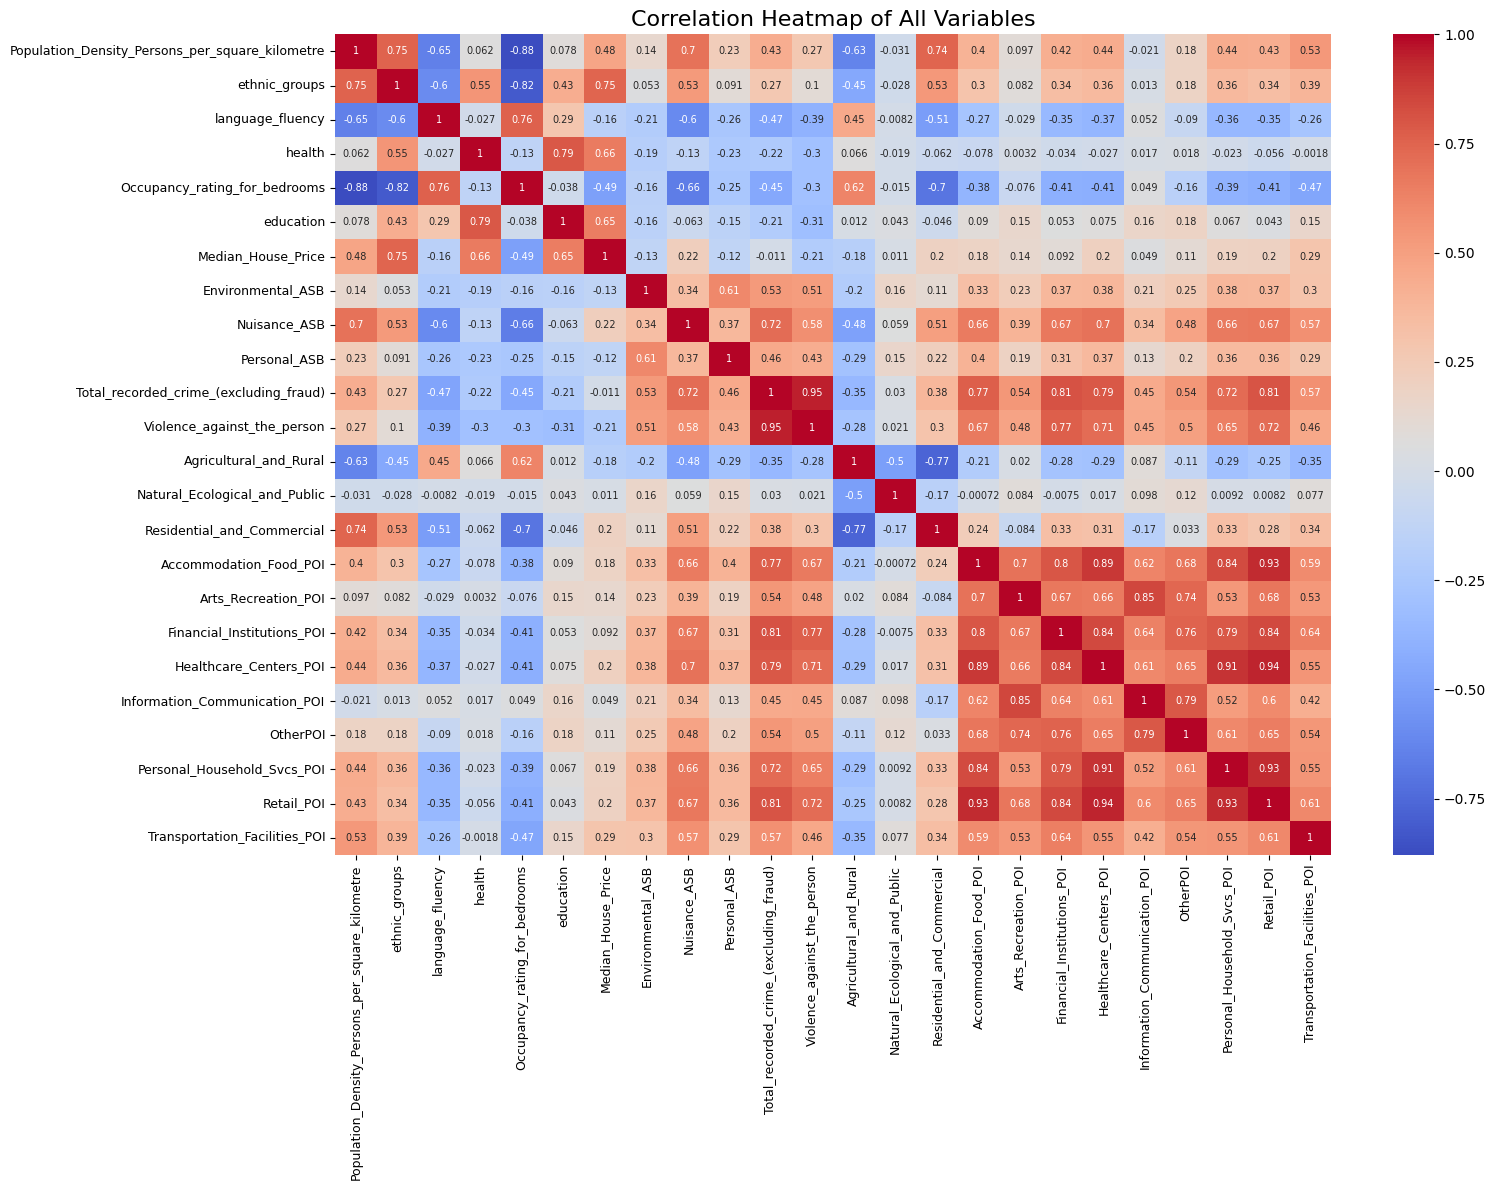

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. 计算相关系数矩阵（可以用X，也可以用X_clean）
corr_matrix = X.corr()  # 或 X_clean.corr()

plt.figure(figsize=(16, 12))
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap='coolwarm',
    annot_kws={"size": 7}
)
plt.title('Correlation Heatmap of All Variables', fontsize=16)
plt.xticks(fontsize=9, rotation=90)  # 让横轴标签垂直
plt.yticks(fontsize=9)
plt.tight_layout()
plt.show()

In [23]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, make_scorer

# 1. 读取数据并将 '..' 替换为 NaN


# 2. 选取变量
features = [
    "Population_Density_Persons_per_square_kilometre",
    "ethnic_groups",
    "Environmental_ASB",
    "Nuisance_ASB",
    "Personal_ASB",
    "Violence_against_the_person",
    "Agricultural_and_Rural",
    "Natural_Ecological_and_Public",
    "Residential_and_Commercial",
    "Arts_Recreation_POI",
    "OtherPOI",
    "Personal_Household_Svcs_POI",
    "Transportation_Facilities_POI"
]
target = "Total_owed_a_prevention_or_relief_duty"

# 3. 数据类型转换（确保所有特征和目标都是数值型）
for col in features + [target]:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# 4. 缺失值处理（丢弃有缺失的行）
data = df[features + [target]].dropna()

X = data[features]
y = data[target]

In [24]:
print(data.isnull().sum())

Population_Density_Persons_per_square_kilometre    0
ethnic_groups                                      0
Environmental_ASB                                  0
Nuisance_ASB                                       0
Personal_ASB                                       0
Violence_against_the_person                        0
Agricultural_and_Rural                             0
Natural_Ecological_and_Public                      0
Residential_and_Commercial                         0
Arts_Recreation_POI                                0
OtherPOI                                           0
Personal_Household_Svcs_POI                        0
Transportation_Facilities_POI                      0
Total_owed_a_prevention_or_relief_duty             0
dtype: int64


In [25]:
model = LinearRegression()
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# 推荐用法
rmse_scores = cross_val_score(model, X, y, cv=kf, scoring='neg_root_mean_squared_error')
rmse_scores = -rmse_scores  # 转为正的RMSE

r2_scores = cross_val_score(model, X, y, cv=kf, scoring='r2')

print("OLS线性回归 10折交叉验证结果:")
print(f"RMSE (均值): {np.mean(rmse_scores):.4f}")
print(f"RMSE (标准差): {np.std(rmse_scores):.4f}")
print(f"R² (均值): {np.mean(r2_scores):.4f}")
print(f"R² (标准差): {np.std(r2_scores):.4f}")

OLS线性回归 10折交叉验证结果:
RMSE (均值): 365.2550
RMSE (标准差): 83.1106
R² (均值): 0.8104
R² (标准差): 0.0643


In [26]:
from sklearn.ensemble import GradientBoostingRegressor

# 定义模型
gbm_model = GradientBoostingRegressor(random_state=42)

# 交叉验证
gbm_rmse_scores = cross_val_score(gbm_model, X, y, cv=kf, scoring='neg_root_mean_squared_error')
gbm_rmse_scores = -gbm_rmse_scores

gbm_r2_scores = cross_val_score(gbm_model, X, y, cv=kf, scoring='r2')

print("梯度提升回归 10折交叉验证结果:")
print(f"RMSE (均值): {np.mean(gbm_rmse_scores):.4f}")
print(f"RMSE (标准差): {np.std(gbm_rmse_scores):.4f}")
print(f"R² (均值): {np.mean(gbm_r2_scores):.4f}")
print(f"R² (标准差): {np.std(gbm_r2_scores):.4f}")


梯度提升回归 10折交叉验证结果:
RMSE (均值): 392.6943
RMSE (标准差): 178.3381
R² (均值): 0.7837
R² (标准差): 0.1458


In [27]:
from sklearn.ensemble import RandomForestRegressor

# 定义模型
rf_model = RandomForestRegressor(random_state=42)

# 交叉验证
rf_rmse_scores = cross_val_score(rf_model, X, y, cv=kf, scoring='neg_root_mean_squared_error')
rf_rmse_scores = -rf_rmse_scores

rf_r2_scores = cross_val_score(rf_model, X, y, cv=kf, scoring='r2')

print("随机森林回归 10折交叉验证结果:")
print(f"RMSE (均值): {np.mean(rf_rmse_scores):.4f}")
print(f"RMSE (标准差): {np.std(rf_rmse_scores):.4f}")
print(f"R² (均值): {np.mean(rf_r2_scores):.4f}")
print(f"R² (标准差): {np.std(rf_r2_scores):.4f}")

随机森林回归 10折交叉验证结果:
RMSE (均值): 386.3677
RMSE (标准差): 182.5722
R² (均值): 0.8057
R² (标准差): 0.1025


In [28]:
import lightgbm as lgb

# 定义模型
lgbm_model = lgb.LGBMRegressor(random_state=42)

# 交叉验证
lgbm_rmse_scores = cross_val_score(lgbm_model, X, y, cv=kf, scoring='neg_root_mean_squared_error')
lgbm_rmse_scores = -lgbm_rmse_scores

lgbm_r2_scores = cross_val_score(lgbm_model, X, y, cv=kf, scoring='r2')

print("LightGBM回归 10折交叉验证结果:")
print(f"RMSE (均值): {np.mean(lgbm_rmse_scores):.4f}")
print(f"RMSE (标准差): {np.std(lgbm_rmse_scores):.4f}")
print(f"R² (均值): {np.mean(lgbm_r2_scores):.4f}")
print(f"R² (标准差): {np.std(lgbm_r2_scores):.4f}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000082 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 901
[LightGBM] [Info] Number of data points in the train set: 220, number of used features: 13
[LightGBM] [Info] Start training from score 990.977273
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

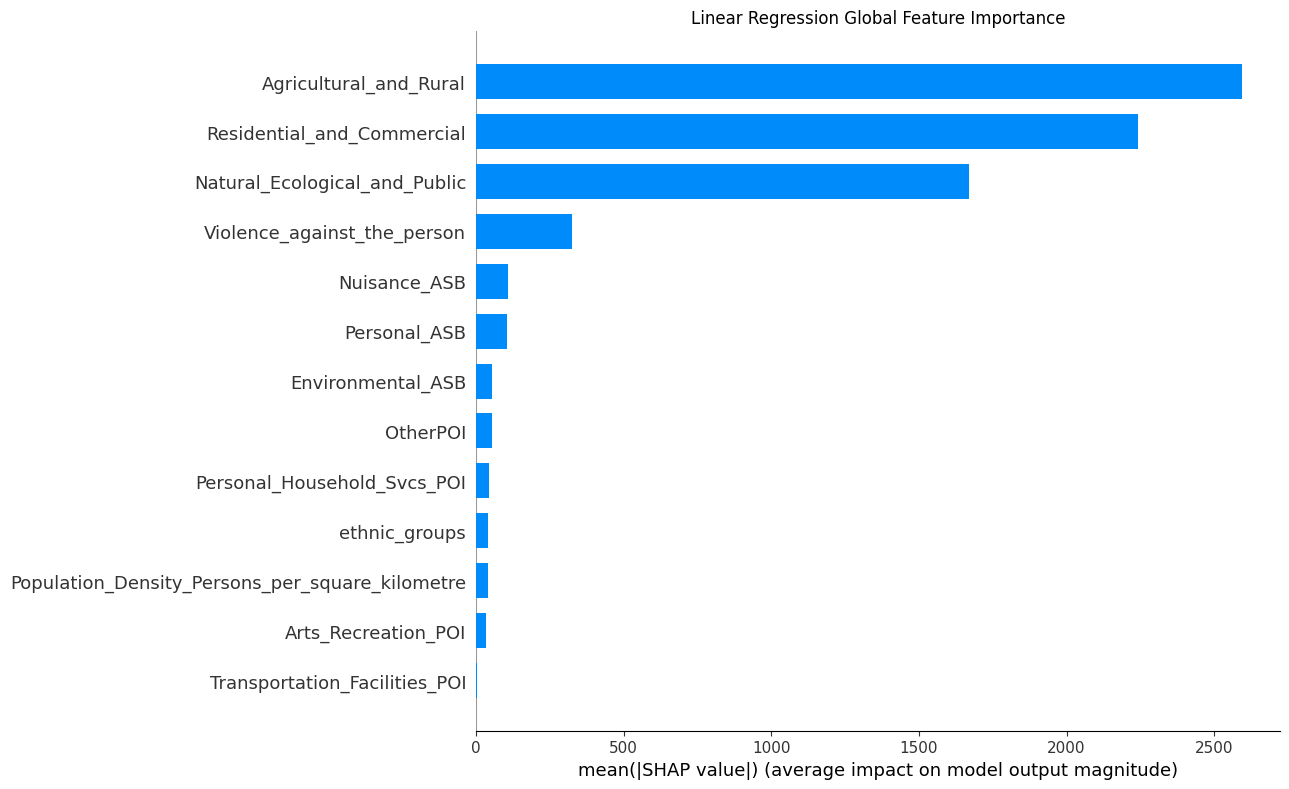

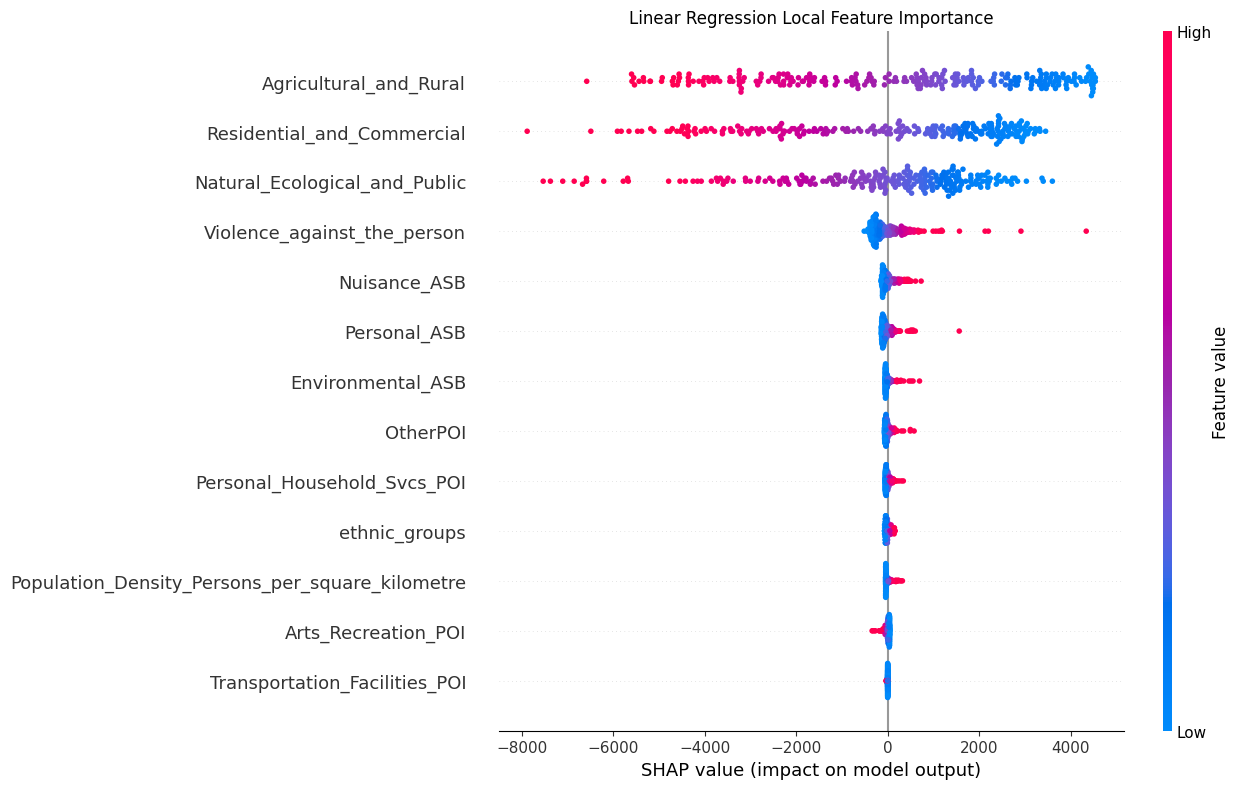

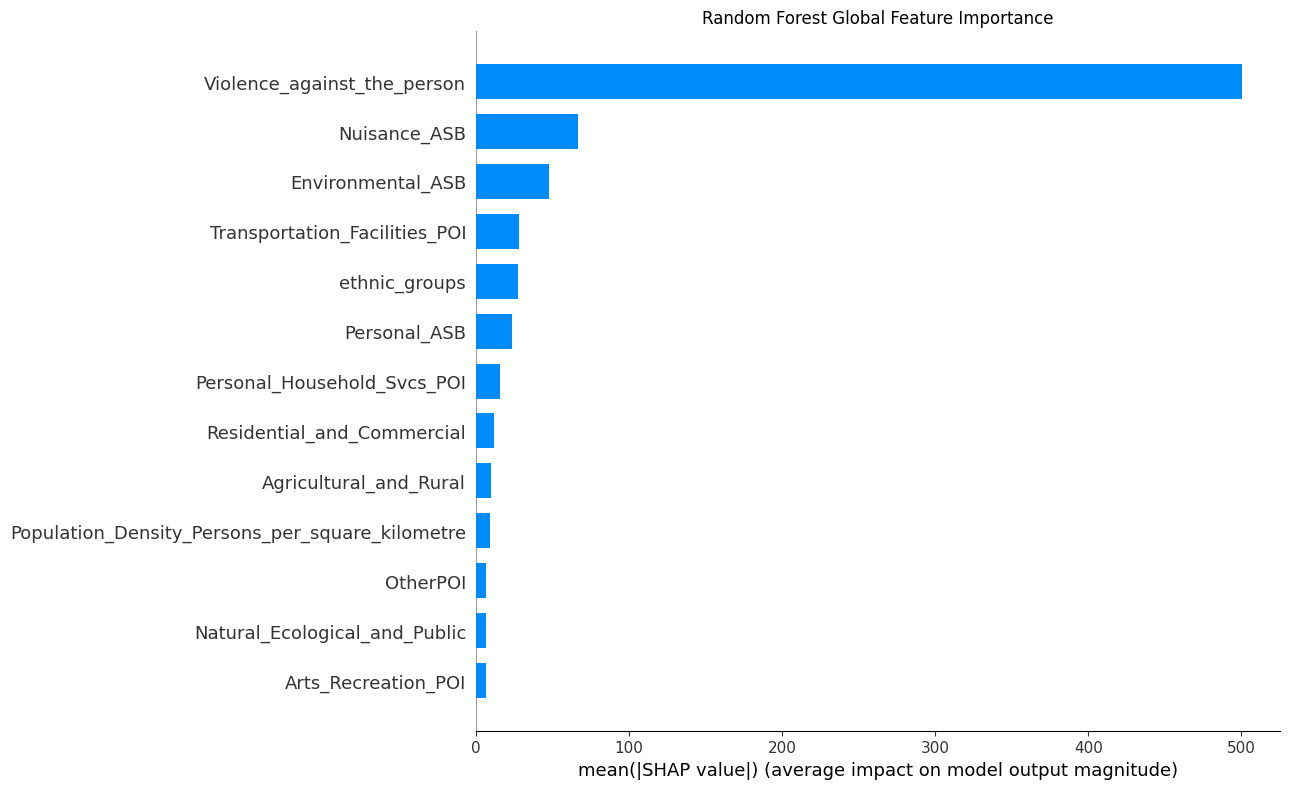

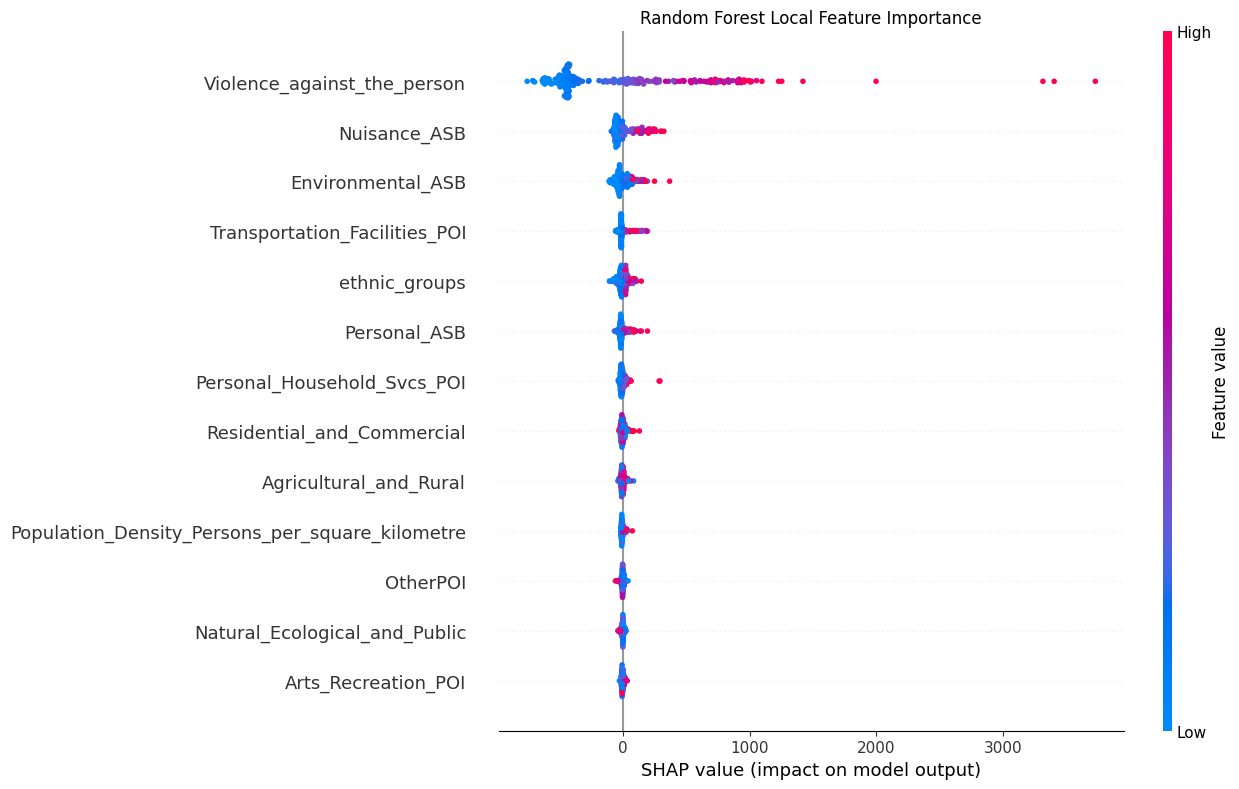

In [29]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import shap
import matplotlib.pyplot as plt

# 假定你已经有X_clean, y_clean，或者用你筛选后的X, y
# 如果你用的是features变量名，则 X = data[features], y = data[target]
X = data[features]
y = data[target]
# 1. 训练OLS线性回归
ols_model = LinearRegression()
ols_model.fit(X, y)

# 2. 训练随机森林
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X, y)

# OLS线性回归
explainer_ols = shap.Explainer(ols_model, X)
shap_values_ols = explainer_ols(X)

# 随机森林
explainer_rf = shap.Explainer(rf_model, X)
shap_values_rf = explainer_rf(X)


# 统一图片大小
def plot_shap_summary(shap_values, X, title, plot_type="dot"):
    shap.summary_plot(
        shap_values, 
        X, 
        feature_names=X.columns, 
        plot_type=plot_type if plot_type=="bar" else None, 
        show=False
    )
    plt.title(title)
    plt.gcf().set_size_inches(13, 8)  # 可根据需要调整宽高
    plt.tight_layout()               # 自动调整布局防止标签被遮挡
    plt.show()

# OLS: Global feature importance (bar)
plot_shap_summary(shap_values_ols, X, "Linear Regression Global Feature Importance", plot_type="bar")

# OLS: Local feature importance (dot)
plot_shap_summary(shap_values_ols, X, "Linear Regression Local Feature Importance", plot_type="dot")

# RF: Global feature importance (bar)
plot_shap_summary(shap_values_rf, X, "Random Forest Global Feature Importance", plot_type="bar")

# RF: Local feature importance (dot)
plot_shap_summary(shap_values_rf, X, "Random Forest Local Feature Importance", plot_type="dot")



#save SHAP plots for OLS and Random Forest，存图专用勿动
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import shap
import matplotlib.pyplot as plt

# 假定你已经有X_clean, y_clean，或者用你筛选后的X, y
# 如果你用的是features变量名，则 X = data[features], y = data[target]

# 1. 训练OLS线性回归
ols_model = LinearRegression()
ols_model.fit(X, y)

# 2. 训练随机森林
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X, y)

# 3. SHAP解释器（OLS）
explainer_ols = shap.Explainer(ols_model, X)
shap_values_ols = explainer_ols(X)

# 4. SHAP解释器（随机森林）
explainer_rf = shap.Explainer(rf_model, X)
shap_values_rf = explainer_rf(X)

# 5. 画 OLS SHAP 图
plt.figure()
shap.summary_plot(shap_values_ols, X, feature_names=X.columns, plot_type="bar", show=False)
plt.title("OLS - Global Feature Importance")
plt.tight_layout()
plt.savefig("OLS_SHAP_global_bar.png", dpi=300)

plt.figure()
shap.summary_plot(shap_values_ols, X, feature_names=X.columns, show=False)
plt.title("OLS - Local Feature Importance")
plt.tight_layout()
plt.savefig("OLS_SHAP_local_scatter.png", dpi=300)

# 6. 画 RF SHAP 图
plt.figure()
shap.summary_plot(shap_values_rf, X, feature_names=X.columns, plot_type="bar", show=False)
plt.title("RF - Global Feature Importance")
plt.tight_layout()
plt.savefig("RF_SHAP_global_bar.png", dpi=300)

plt.figure()
shap.summary_plot(shap_values_rf, X, feature_names=X.columns, show=False)
plt.title("RF - Local Feature Importance")
plt.tight_layout()
plt.savefig("RF_SHAP_local_scatter.png", dpi=300)

print("SHAP图已保存，分别为OLS和随机森林的全局/局部特征重要性！")


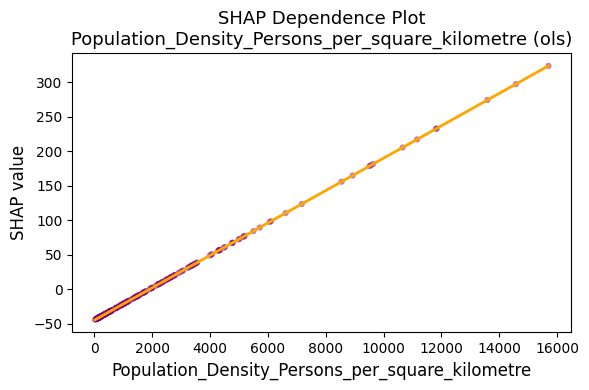

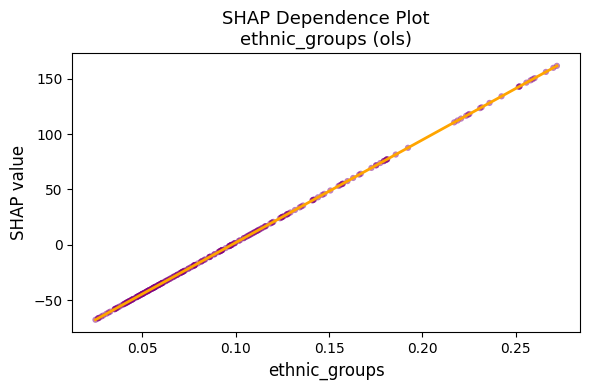

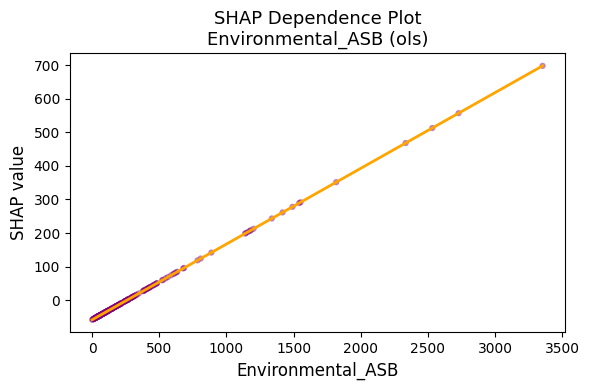

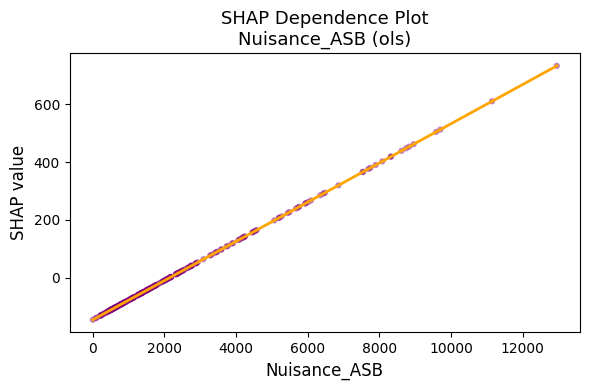

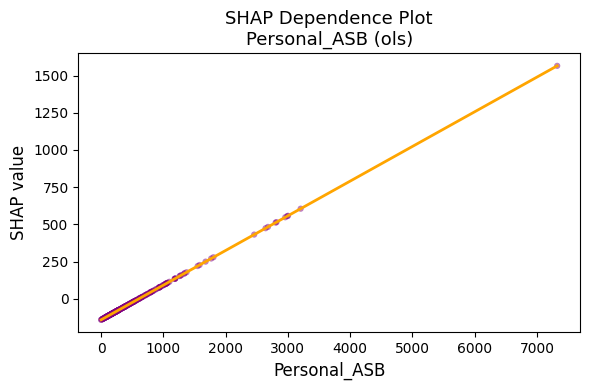

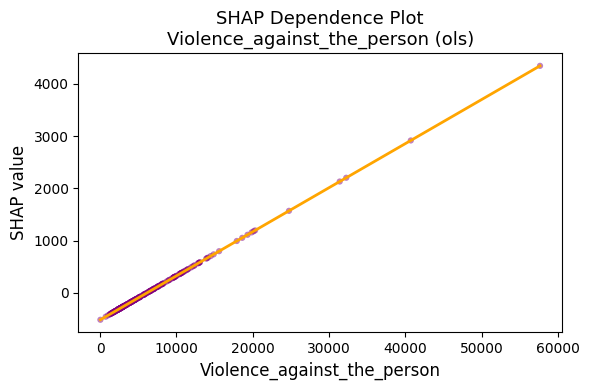

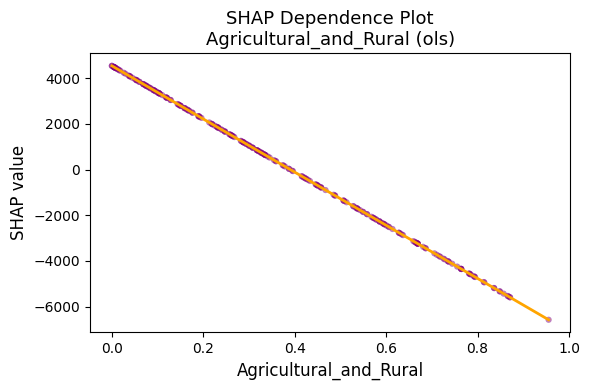

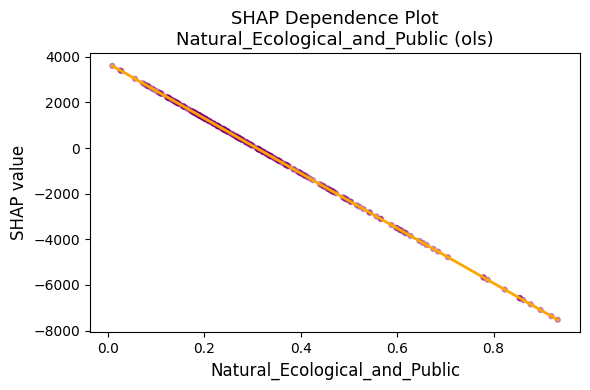

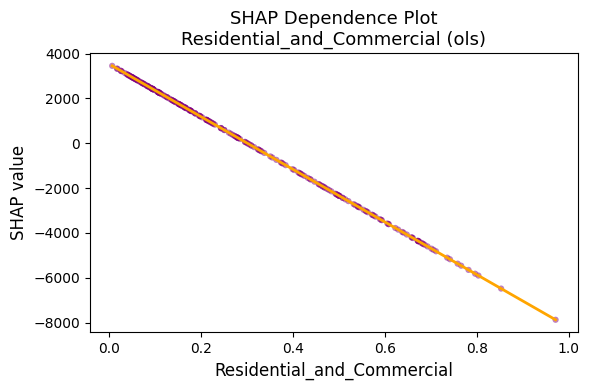

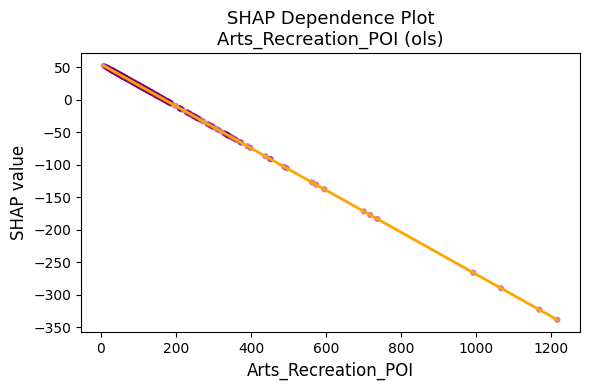

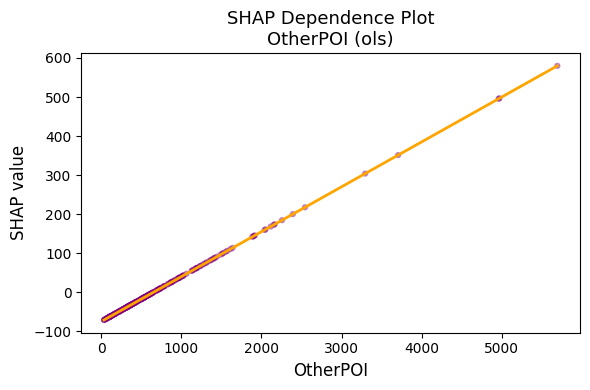

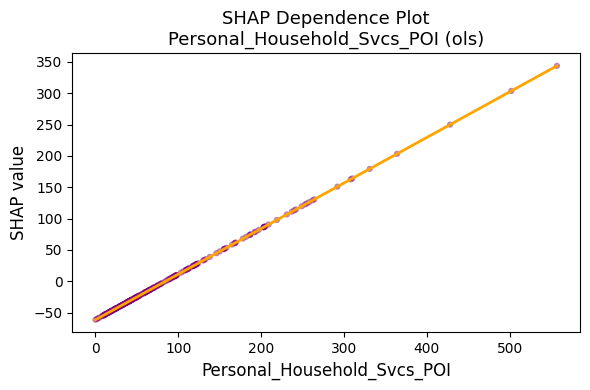

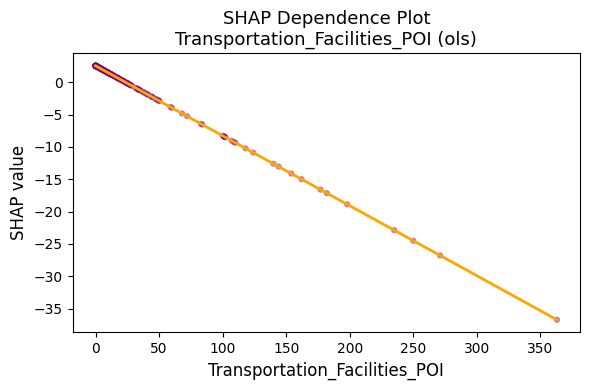

ols 的 SHAP 依赖图已保存在 output/LDP\ols 文件夹下。


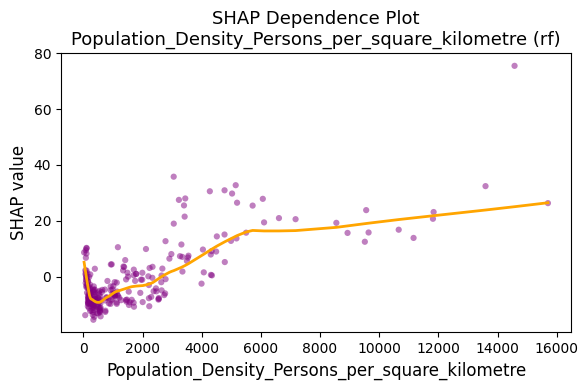

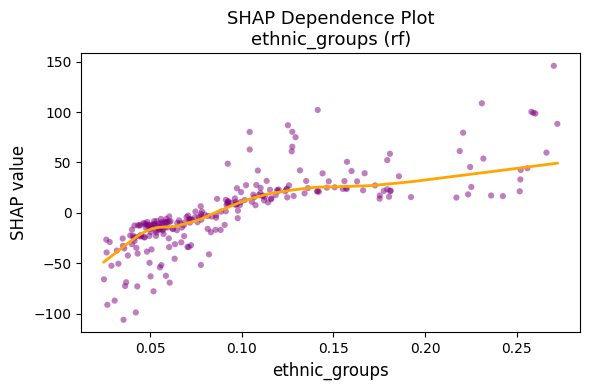

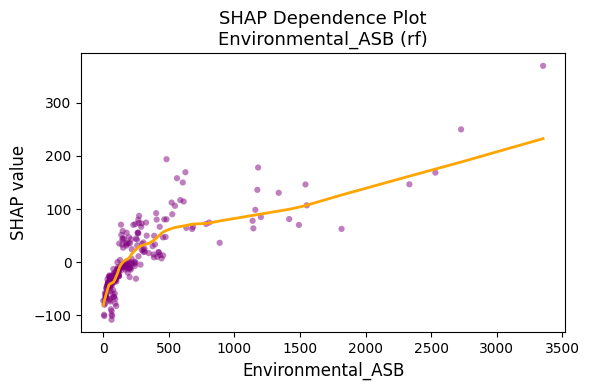

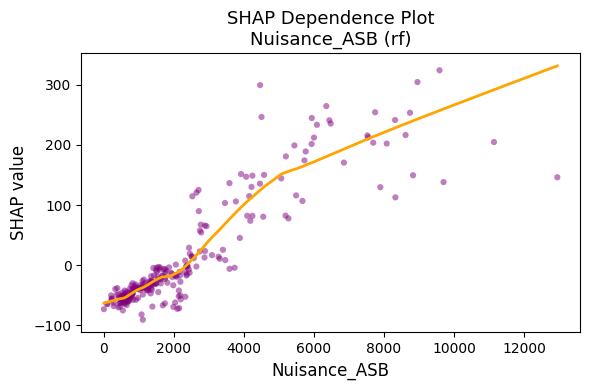

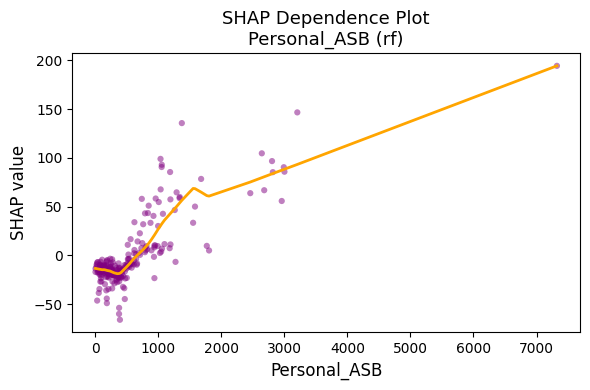

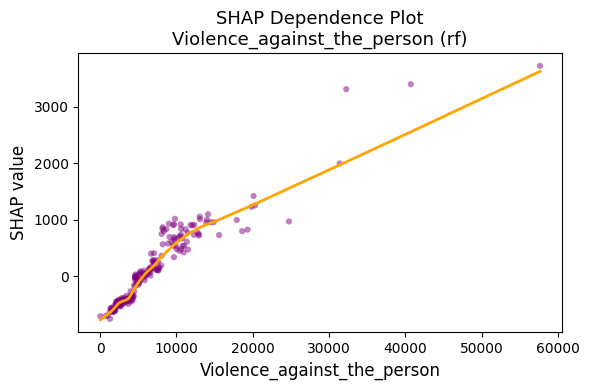

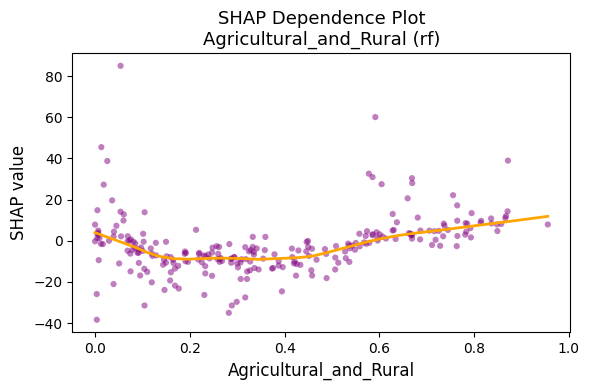

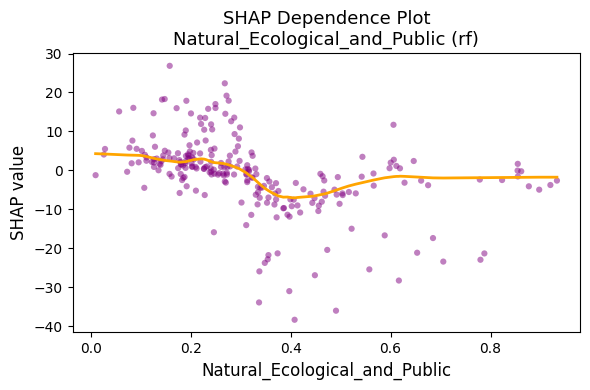

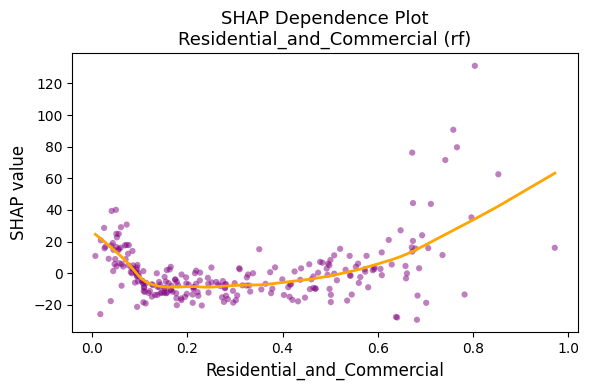

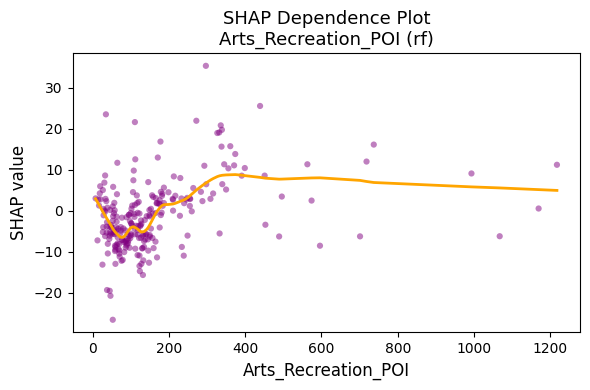

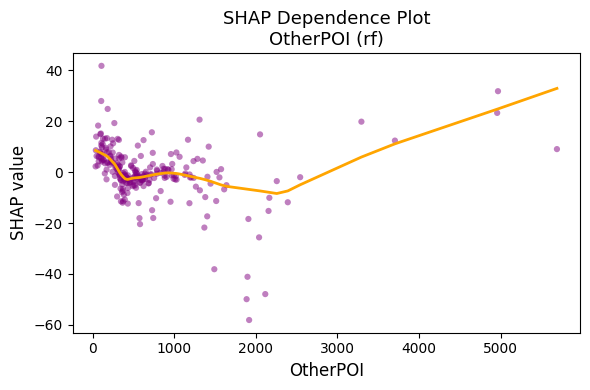

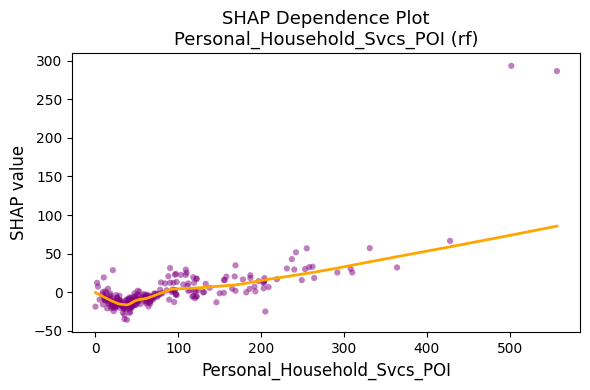

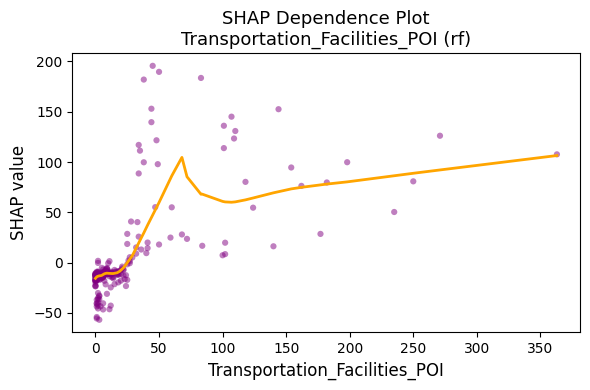

rf 的 SHAP 依赖图已保存在 output/LDP\rf 文件夹下。


In [18]:
import os
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess

def plot_shap_dependence_all(X, shap_values, features, model_name, save_dir, show=True):
    """
    绘制所有特征的SHAP依赖图，并保存到指定模型子文件夹，同时可选择是否显示在notebook里
    """
    # 1. 兼容shap.Explanation对象和numpy数组
    if hasattr(shap_values, "values"):
        shap_array = shap_values.values
    else:
        shap_array = shap_values

    # 2. 创建模型专属目录
    model_dir = os.path.join(save_dir, model_name)
    os.makedirs(model_dir, exist_ok=True)

    # 3. 循环画图
    for idx, feat in enumerate(features):
        x = X[feat].values.flatten()
        y_shap = shap_array[:, idx].flatten()

        # 跳过含有缺失值或非数值型的特征
        if np.any(pd.isnull(x)) or np.any(pd.isnull(y_shap)):
            print(f"特征 {feat} 含缺失值，跳过。")
            continue
        if not (np.issubdtype(x.dtype, np.number) and np.issubdtype(y_shap.dtype, np.number)):
            print(f"特征 {feat} 包含非数值型数据，跳过。")
            continue

        plt.figure(figsize=(6, 4))
        plt.scatter(x, y_shap, alpha=0.5, s=20, color='purple', edgecolor='none')
        # LOWESS平滑线
        lowess_line = lowess(y_shap, x, frac=0.3)
        plt.plot(lowess_line[:, 0], lowess_line[:, 1], color='orange', linewidth=2)
        plt.xlabel(feat, fontsize=12)
        plt.ylabel(f"SHAP value", fontsize=12)
        plt.title(f"SHAP Dependence Plot\n{feat} ({model_name})", fontsize=13)
        plt.tight_layout()
        plt.savefig(f'{model_dir}/{feat}_ldp_lowess.png', dpi=300)
        if show:
            plt.show()  # 在notebook里显示当前图像
        plt.close()
    print(f"{model_name} 的 SHAP 依赖图已保存在 {model_dir} 文件夹下。")

# 用法示例
plot_shap_dependence_all(X, shap_values_ols, features, model_name="ols", save_dir="output/LDP", show=True)
plot_shap_dependence_all(X, shap_values_rf, features, model_name="rf", save_dir="output/LDP", show=True)
